In [75]:
import numpy as np

In [76]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

server = "localhost,5432"
db_name = "ModMon"
driver = "/usr/local/lib/psqlodbcw.so"

cnxn = pyodbc.connect("DRIVER={" + driver + "};SERVER=" + server + ";DATABASE=" + db_name + ";Trusted_Connection=yes;")
cursor = cnxn.cursor()

In [137]:
query = """select modelid, count(modelid) AS versions from modelVersions group by modelid;"""
temp = pd.read_sql(
            query,
            cnxn,
        )
query = """
        SELECT m.name AS Model, mv.modelid, mv.modelversion AS active_version, Q.description AS Question, m.teamName AS Team
        FROM modelVersions as mv, models AS m, researchQuestions AS q
        WHERE m.questionID = q.questionID
        AND mv.modelid = m.modelid
        AND mv.active;
        """
metadata = pd.read_sql(
            query,
            cnxn,
        )
metadata

,model,modelid,active_version,question,team
0,synpuf-python,2,2.0,Predict the gender of patients,The A-Team
1,synpuf-R,1,1.0,Predict the gender of patients,Another Team
2,synpuf_stats,3,0.0.1,Descriptive stats for Synpuf database,REG


In [141]:
pd.merge(metadata, temp, on='modelid')[['model', 'versions', 'active_version', 'question', 'team']]

,model,versions,active_version,question,team
0,synpuf-python,2,2.0,Predict the gender of patients,The A-Team
1,synpuf-R,1,1.0,Predict the gender of patients,Another Team
2,synpuf_stats,1,0.0.1,Descriptive stats for Synpuf database,REG


Visualisation ideas
==

In [78]:
results_table = pd.read_sql('SELECT * FROM results;', cnxn)
results_table.head()

,modelid,modelversion,testdatasetid,isreferenceresult,runtime,runid,metric,value,valueerror,resultmessage
0,1,1.0,2,1,2020-07-23,1,AUC,0.6690,None,None
1,1,1.0,2,1,2020-07-23,1,LogLoss,0.6371,None,None
2,2,1.0,4,1,2020-07-29,2,accuracy,0.6550,None,None
3,2,1.0,4,1,2020-07-29,2,AUC,0.7040,None,None
4,2,2.0,6,1,2020-07-29,3,accuracy,0.6690,None,None


[Text(0, 0.5, 'Runs in ModMon DB'), Text(0.5, 0, 'Model')]

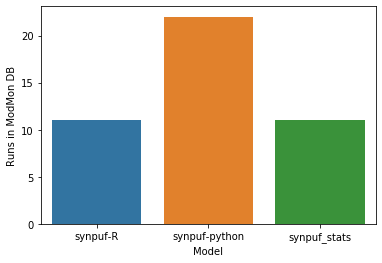

In [79]:
# Number of times each model has been run
query = """
SELECT m.name, COUNT( DISTINCT r.runid )
FROM results AS r, models AS m
WHERE r.modelid = m.modelid
GROUP BY m.name;
"""
data = pd.read_sql(query, cnxn)
bar = sns.barplot(x='name', y='count', data=data)
bar.set(xlabel='Model', ylabel="Runs in ModMon DB")

In [80]:
query = """
SELECT m.name, r.metric, r.value, d.databasename, d.datasetid, m.modelid, r.modelversion, q.description
FROM results AS r, datasets AS d, models AS m, researchQuestions AS q
WHERE r.testdatasetid = d.datasetid
AND r.modelid = m.modelid
AND m.questionid = q.questionid
AND NOT r.isreferenceresult;
"""
results = pd.read_sql(query, cnxn)
results = results.sort_values(by=['modelid', 'datasetid'])
results

,name,metric,value,databasename,datasetid,modelid,modelversion,description
0,synpuf-R,AUC,0.5857,WEEK_01,7,1,1.0,Predict the gender of patients
1,synpuf-R,LogLoss,0.6960,WEEK_01,7,1,1.0,Predict the gender of patients
12,synpuf-R,AUC,0.5233,WEEK_02,9,1,1.0,Predict the gender of patients
13,synpuf-R,LogLoss,0.7347,WEEK_02,9,1,1.0,Predict the gender of patients
24,synpuf-R,AUC,0.5184,WEEK_03,10,1,1.0,Predict the gender of patients
...,...,...,...,...,...,...,...,...
115,synpuf_stats,aug_births,83.0000,WEEK_10,17,3,0.0.1,Descriptive stats for Synpuf database
116,synpuf_stats,born_60,7.0000,WEEK_10,17,3,0.0.1,Descriptive stats for Synpuf database
117,synpuf_stats,population_size,1000.0000,WEEK_10,17,3,0.0.1,Descriptive stats for Synpuf database
118,synpuf_stats,mortality,5.2000,WEEK_10,17,3,0.0.1,Descriptive stats for Synpuf database


In [81]:
results['model'] = results['name'] + '_' + results['modelversion']
results['titles'] = results['metric'] + ' (' + results['description'] + ')'
results.head()

,name,metric,value,databasename,datasetid,modelid,modelversion,description,model,titles
0,synpuf-R,AUC,0.5857,WEEK_01,7,1,1.0,Predict the gender of patients,synpuf-R_1.0,AUC (Predict the gender of patients)
1,synpuf-R,LogLoss,0.6960,WEEK_01,7,1,1.0,Predict the gender of patients,synpuf-R_1.0,LogLoss (Predict the gender of patients)
12,synpuf-R,AUC,0.5233,WEEK_02,9,1,1.0,Predict the gender of patients,synpuf-R_1.0,AUC (Predict the gender of patients)
13,synpuf-R,LogLoss,0.7347,WEEK_02,9,1,1.0,Predict the gender of patients,synpuf-R_1.0,LogLoss (Predict the gender of patients)
24,synpuf-R,AUC,0.5184,WEEK_03,10,1,1.0,Predict the gender of patients,synpuf-R_1.0,AUC (Predict the gender of patients)


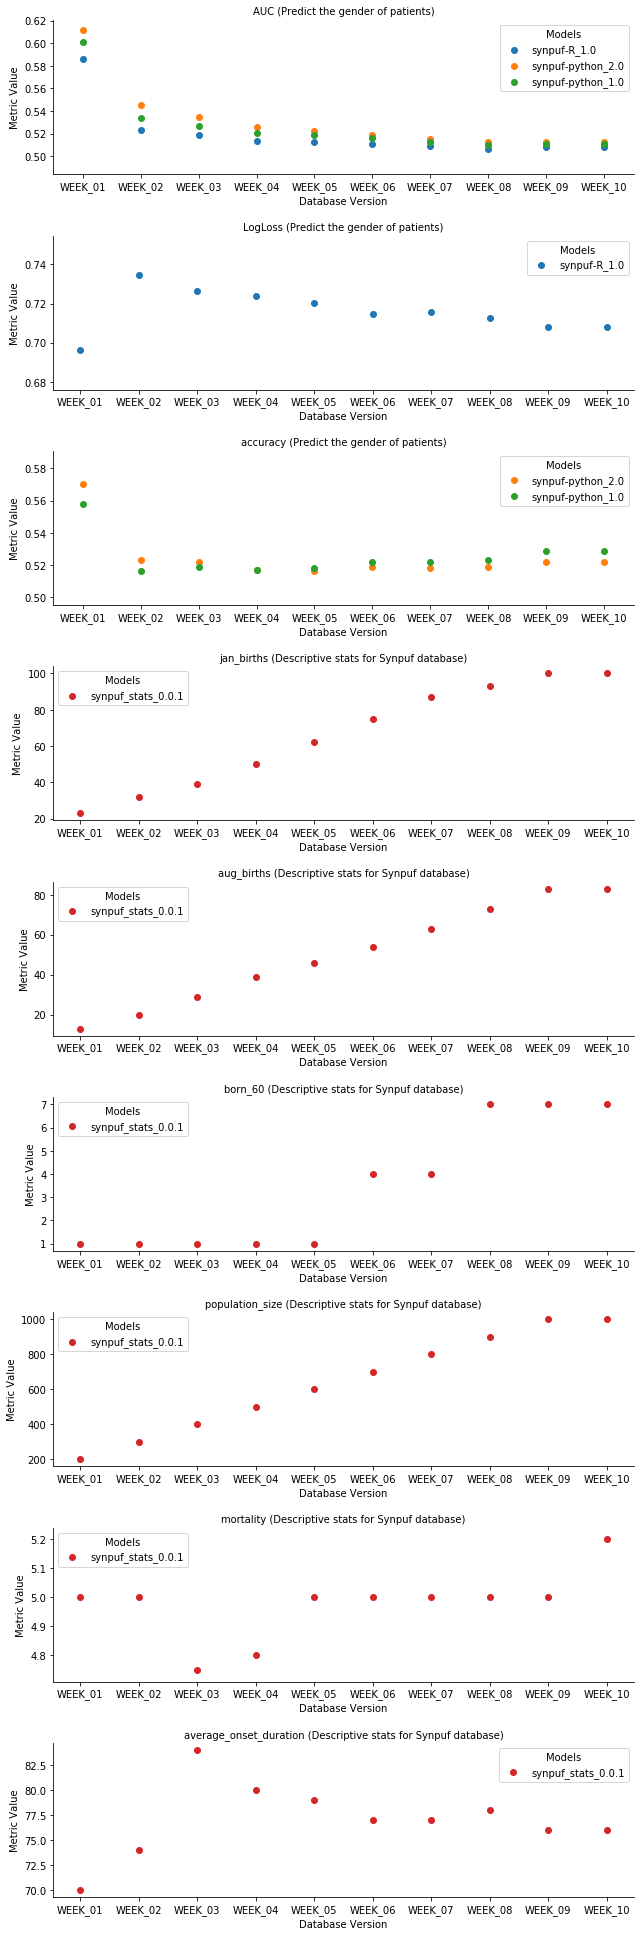

In [82]:
g = sns.FacetGrid(data=results, row='titles', sharey=False, sharex=False, aspect=3, hue='model')
g.map(plt.scatter, "databasename", "value").fig.subplots_adjust(hspace=.4)
g.set(xlabel='Database Version', ylabel='Metric Value')
g.set_titles(col_template = "{col_name}", row_template = '{row_name}')
for i, _ in enumerate(g.axes):
    g.axes[i][0].legend(title = "Models")

In [83]:
reduced_results = results.loc[results['datasetid'].isin([max(results['datasetid']), min(results['datasetid'])])].copy()
reduced_results['model_metric'] = reduced_results['model'] + '_' + reduced_results['metric']
reduced_results.head()

,name,metric,value,databasename,datasetid,modelid,modelversion,description,model,titles,model_metric
0,synpuf-R,AUC,0.5857,WEEK_01,7,1,1.0,Predict the gender of patients,synpuf-R_1.0,AUC (Predict the gender of patients),synpuf-R_1.0_AUC
1,synpuf-R,LogLoss,0.6960,WEEK_01,7,1,1.0,Predict the gender of patients,synpuf-R_1.0,LogLoss (Predict the gender of patients),synpuf-R_1.0_LogLoss
108,synpuf-R,AUC,0.5078,WEEK_10,17,1,1.0,Predict the gender of patients,synpuf-R_1.0,AUC (Predict the gender of patients),synpuf-R_1.0_AUC
109,synpuf-R,LogLoss,0.7080,WEEK_10,17,1,1.0,Predict the gender of patients,synpuf-R_1.0,LogLoss (Predict the gender of patients),synpuf-R_1.0_LogLoss
2,synpuf-python,accuracy,0.5700,WEEK_01,7,2,2.0,Predict the gender of patients,synpuf-python_2.0,accuracy (Predict the gender of patients),synpuf-python_2.0_accuracy


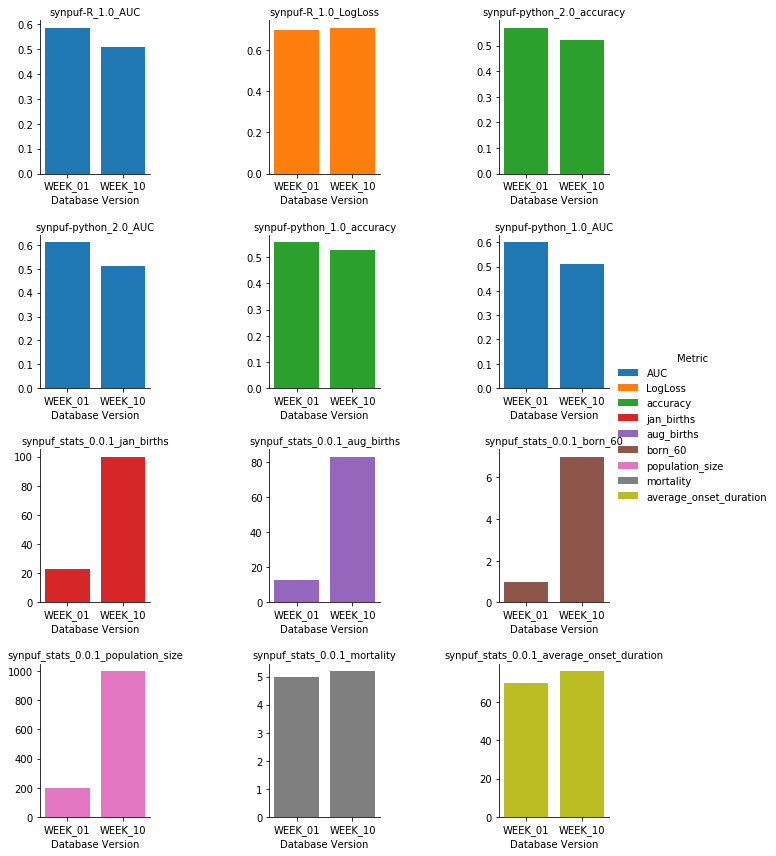

In [143]:
g1 = sns.FacetGrid(data=reduced_results, col='model_metric', col_wrap=3, sharey=False, sharex=False, hue='metric')
g1.map(plt.bar, "databasename", "value").fig.subplots_adjust(hspace=.4)
g1.set(xlabel='Database Version', ylabel=None)
g1.set_titles(col_template = "{col_name}")
g1.add_legend(title="Metrics")

In [86]:
cnxn.close()